# Periodic Repetition of Lockdowns and its Effects in the SIR Modell

In [1]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from scipy.integrate import odeint
from scipy.integrate import solve_ivp # Besserer Integrator

In [109]:

R0_in = 0.7
R0_out = 1.5
lamda = 0.5
beta = 0.12
l = 100
mindt = 0.5

period = np.linspace(1, 100, l, endpoint =True)

partIn = np.linspace(0, 1, l, endpoint =True)


oldTime = 0


## A new possible lockdown function

Divide the population into different classes:
- Vaccinated and non Vaccinated
- Single Flat and shared Flat
    - At the beginnig of the lockdown if there is an infected Person in a shared flat, it is likely, that everybody there gets it.
    - Maybe simulate the effect of new Lockdown Measures with an exponential curve $$a exp(-\lambda * t) + R_{basis}$$
- Tested + Isolated and not Tested positive cases

In [119]:
# Possibly faster lockdown function

def lockdown(t, partIn, periods, R_values):
    daysInPeriod = np.mod(t, periods)
    # Positive, if in Lockdown
    daysInLockdown = daysInPeriod - np.outer(1-partIn, period)
    isLockdown = daysInLockdown > 0
    Rs = np.ones(daysInLockdown.shape)
    Rs[isLockdown] = np.exp(-lamda * (daysInLockdown[isLockdown]+1)) + R0_in
    Rs[np.logical_not(isLockdown)] = R0_out
    
    return Rs.T*beta

## A test of the lockdown function:

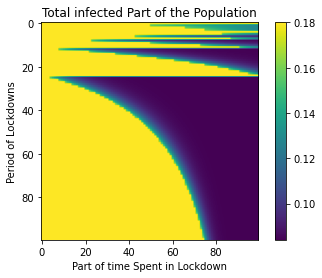

In [111]:
plt.imshow(lockdown(25, partIn, period))
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Total infected Part of the Population")
plt.colorbar()

The Lockdown function is working correctly. Now Implement the odes so that it works for matrizes:
For this I use a basic SIR-modell
$$\dot x = - \alpha *x*y$$
$$\dot z = \beta *y$$
$$\dot y = -(dx+dz)$$

In [112]:

def odes(t, p, lockdown):
    x = p[:l*l]
    y = p[l*l:2*l*l]
    z = p[2*l*l:]
    
    alpha = lockdown(t, partIn, period).flatten()
    
    dx = - alpha *x*y
    dz = beta *y
    dy = -(dx+dz)
    
    return np.concatenate([dx,dy,dz])

Set the lockdown Paramters

Choose the Starting Parameters

In [113]:


N = 8.2 * 10**7
infected = 2* 10**5/N
removed = 2.1*10**6/N
notInfected = 1 - infected - removed

matrix = np.ones((l,l))
p0 = np.array([notInfected*matrix, infected*matrix, removed *matrix]).flatten()


In [114]:

sol = solve_ivp(odes, (0,600), p0, max_step=mindt, args=(lockdown,))
p=sol.y
t = sol.t
x = p[:l*l, :]
y = p[l*l:2*l*l, :]
z = p[2*l*l:, :]

In [115]:
x = x.reshape(l,l,len(t))
y = y.reshape(l,l,len(t))
z = z.reshape(l,l,len(t))

In [116]:
total_infected = (1-x)[:,:,-1]
plt.figure(2, (4,4), 300)
plt.imshow(total_infected, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Total infected Part of the Population")
plt.colorbar()

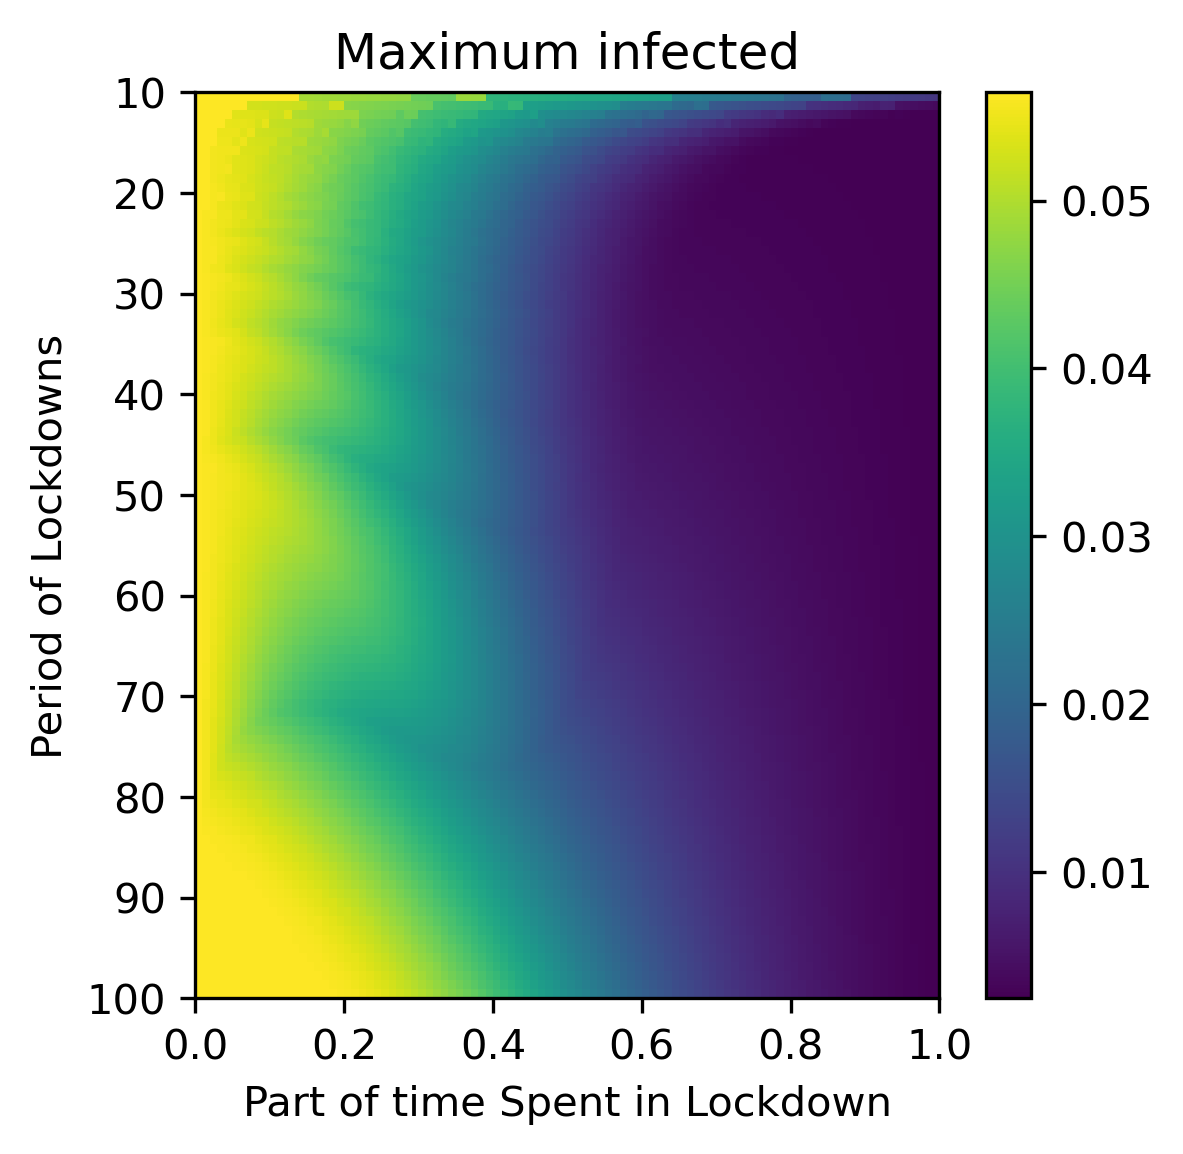

In [117]:
max_infected = np.amax(y, 2)
plt.figure(1, (4,4), 300)
plt.imshow(max_infected, extent=extend, aspect='auto')
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Maximum infected")
plt.colorbar()

In [118]:
max_infected = np.amax(y, 2)*0.02*N
plt.figure(3, (4,4), 300)
plt.imshow(max_infected, extent=extend, aspect='auto', vmax=20000)
plt.xlabel("Part of time Spent in Lockdown")
plt.ylabel("Period of Lockdowns")
plt.title("Number of People in Hospital")
plt.colorbar()